$$\require{mhchem}$$
# Test case - $\ce{LiFeSO4F}$

Here we use M3GNet to search for low energy $\ce{LiFeSO4F}$ structures. 
The DFT results have been previously published here: https://aip.scitation.org/doi/full/10.1063/5.0076220.



In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    

import warnings
from pathlib import Path
from ase.io import read
import ase
from m3gnet.models import Relaxer
from pymatgen.ext.matproj import MPRester
from pymatgen.core import Structure

import pandas as pd

from tqdm import tqdm

2023-03-28 13:30:38.396971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 13:30:38.458240: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
lifeso4f_mp = Structure.from_file("LiFeSO4F-mp-943492.vasp")

In [3]:

relaxer = Relaxer()

results = relaxer.relax(lifeso4f_mp)
lifeso4f_mp_relaxed = results['final_structure']
lifeso4f_mp_relaxed_energy = results['trajectory'].energies[-1] / len(lifeso4f_mp_relaxed.sites)
lifeso4f_mp_relaxed_volume = lifeso4f_mp_relaxed.volume / len(lifeso4f_mp_relaxed.sites)

2023-03-28 13:30:42.687919: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-28 13:30:42.688000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (OdinComet): /proc/driver/nvidia/version does not exist
2023-03-28 13:30:42.688601: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def load_dataset(names):
    cells = [read(x) for x in  tqdm(names)]
    for atoms, name in zip(cells, input_names):
        atoms.info['fname'] = name.stem

    dataset = []
    for atoms in cells:
        dataset.append(
        {
            'atoms': atoms,
            'label': atoms.info['fname'],
            'energy': atoms.info['energy'],
            'energy_per_atom': atoms.info['energy'] / len(atoms),
            'volume': atoms.get_volume(),
            'volume_per_atom': atoms.get_volume() / len(atoms),

        }
        )

    return pd.DataFrame(dataset).sort_values('energy_per_atom')

Load calculated data

In [5]:
input_names = list(Path("LiFeSO4F-run1").glob("*.res"))
df_dft = load_dataset(input_names)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3868/3868 [00:03<00:00, 1152.80it/s]


In [6]:
input_names = list(Path("LiFeSO4F-run1-m3gnet").glob("*.res"))
df_m3g = load_dataset(input_names)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3868/3868 [00:02<00:00, 1367.10it/s]


In [7]:
input_names = list(Path("LiFeSO4F-relaxed-m3gnet").glob("*.res"))
df_relaxed_m3g = load_dataset(input_names)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3868/3868 [00:03<00:00, 1286.52it/s]


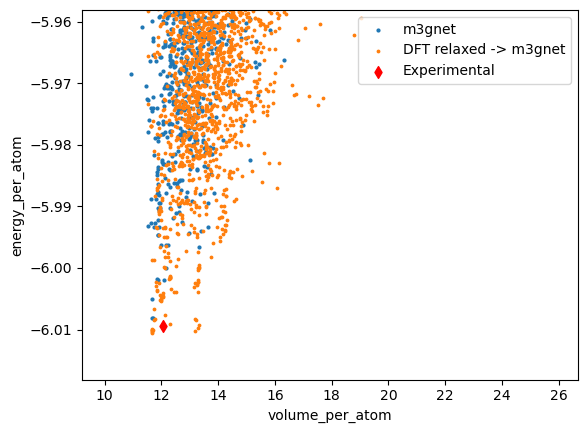

In [8]:
ax = df_m3g.plot.scatter('volume_per_atom', 'energy_per_atom', label='m3gnet', s=4)
ax = df_relaxed_m3g.plot.scatter('volume_per_atom', 'energy_per_atom', label='DFT relaxed -> m3gnet', ax=ax, color='C1', s=3)
ax.scatter( [lifeso4f_mp_relaxed_volume], [lifeso4f_mp_relaxed_energy],  marker='d', color='r', label='Experimental')
min_eng = df_m3g.energy_per_atom.min()
#ax.set_xlim(10, 15)
ax.set_ylim(min_eng-0.01, min_eng+ 0.05)
ax.legend(loc=1)

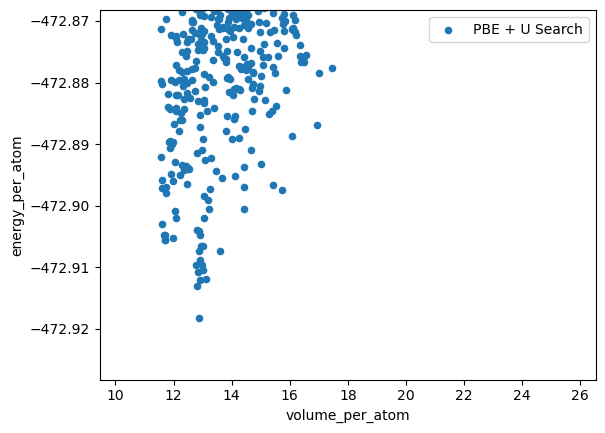

In [9]:
ax = df_dft.plot.scatter('volume_per_atom', 'energy_per_atom', 
                         #xlim=(9, 14), ylim=(-434, -433.75), 
                         label='PBE + U Search')
min_eng = df_dft.energy_per_atom.min()
ax.set_ylim(min_eng-0.01, min_eng+ 0.05)

ax.legend(loc=1)

In [10]:
df_dft.iloc[:3]

,atoms,label,energy,energy_per_atom,volume,volume_per_atom
3018,"(Atom('Li', [2.059504020548763, -1.98859034554...",2LiFeSO4F-200804-034722-678938,-7566.69161,-472.918226,206.246318,12.890395
3164,"(Atom('Li', [-1.5226934928220406, -0.933181268...",2LiFeSO4F-200804-022644-43b3f4,-7566.60922,-472.913076,204.850115,12.803132
2308,"(Atom('Li', [1.506788176531176, 2.578680510737...",2LiFeSO4F-200804-022154-9da9fb,-7566.59285,-472.912053,206.697060,12.918566


In [11]:
df_relaxed_m3g.iloc[:5]

,atoms,label,energy,energy_per_atom,volume,volume_per_atom
3092,"(Atom('Li', [-4.040317086726308, 1.32106399150...",2LiFeSO4F-200818-173807-f55f90,-96.1692,-6.010575,186.573736,11.660858
1536,"(Atom('Li', [2.1532730716003248, 2.26455243755...",4LiFeSO4F-200804-093629-270f26,-192.3336,-6.010425,373.230599,11.663456
2838,"(Atom('Li', [2.581405187021502, -0.07824537357...",2LiFeSO4F-200804-043547-80a807,-96.1644,-6.010275,186.725737,11.670359
3018,"(Atom('Li', [1.9857412726393426, -2.0377037880...",2LiFeSO4F-200804-034722-678938,-96.1630,-6.010187,210.991581,13.186974
120,"(Atom('Li', [2.1975093962436243, 2.15060793465...",2LiFeSO4F-200819-000200-50146f,-96.1623,-6.010144,186.818119,11.676132


In [12]:
df_m3g.iloc[:5]

,atoms,label,energy,energy_per_atom,volume,volume_per_atom
1932,"(Atom('Li', [1.3735649173482027, -1.3091754241...",2LiFeSO4F-200804-055229-a4aef3,-96.1300,-6.008125,186.933079,11.683317
2838,"(Atom('Li', [2.6514121507508763, 0.08089966622...",2LiFeSO4F-200804-043547-80a807,-96.1298,-6.008113,187.268464,11.704279
1755,"(Atom('Li', [1.4096927825611902, -1.3846909426...",2LiFeSO4F-200818-200625-fa2e89,-96.0803,-6.005019,186.519101,11.657444
1468,"(Atom('Li', [-1.7653730722637455, 1.6448893698...",2LiFeSO4F-200804-031846-78332d,-96.0316,-6.001975,193.350160,12.084385
120,"(Atom('Li', [2.5749066880092033, 2.11354669305...",2LiFeSO4F-200819-000200-50146f,-96.0316,-6.001975,189.802136,11.862633


### Comments

Search using M3GNet for relaxation is not able to reproduce the DFT results. 
However, M3GNet does give a reasonable good description for the low energy structures. In particular, the DFT lowest energy strucure `678938` is also found to be one of the lowest energy structure.

Intestingly, *f55f90* (in `df_relaxed_m3g`) and *a4aef3* in (`df_m3g`) has almost the same structure but hte energies are different by 2 meV and almost identical structures have been found for them separately.  

Could this indicate that the potential energy of M3GNet is slightly rugged with smaller basins? 

## Histogram

In [13]:
import matplotlib.pyplot as plt

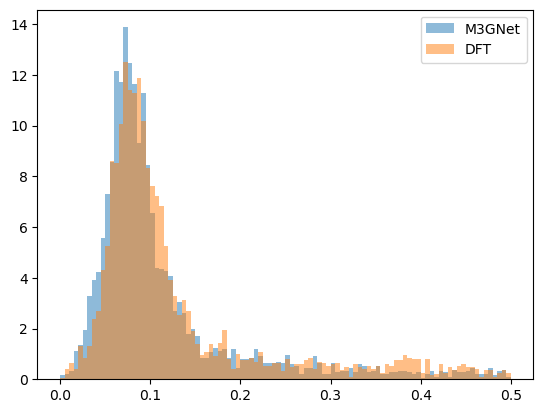

In [14]:
engs = df_m3g['energy_per_atom'].values.copy()
engs_m3g = engs - lifeso4f_mp_relaxed_energy
engs = df_dft['energy_per_atom'].values.copy()
engs_dft = engs - engs.min()

plt.hist(engs_m3g, bins=100,alpha=0.5, density=True, range=(0, 0.5), label='M3GNet');
plt.hist(engs_dft, bins=100, alpha=0.5, density=True, range=(0, 0.5), label='DFT');
plt.legend()

## Concluding remark

Reproducing the DFT search results using M3GNet appears to be more challenging for $\ce{LiFeSO4F}$.
In particular, the polymorphs with silimanite ordering appears to be completely missing.  

However, M3GNet does give good descriptions of their energies as re-relaxing the DFT structures result in one of the lowest energy structures.
This suggest that M3GNet does well when interpolating - even if there are little $\ce{LiFeSO4F}$ data in the training set, there are plenty of training data in the composition space of Li-Fe-S-O-F.
